In [1]:
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
import matplotlib.pyplot as plt
import os
import imghdr
import numpy as np
import random
import shutil

#  I: prepare data

In [2]:
data_dir = 'Car-Bike-Dataset'
img_error = 'img_error'
image_exts = ['jpeg','jpg','bmp','png']

In [3]:
name_dir = os.listdir(data_dir)
len_dir = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir]
print(len_dir)

[2000, 2000]


In [8]:
# dung de xoa cac dinh dang anh khong phu hop
def remove_img(data_dir , image_exts):
    for img in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir , img)):
            image_path = os.path.join(data_dir , img , image)
            try:
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('image not in ext {}'.format(image_path))
                    #os.remove(image_path)
                    shutil.move(image_path,img_error)
            except Exception as e:
                print('Issure not image {}'.format(image_path))
                #os.remove(image_path)
                shutil.move(image_path,img_error)

In [9]:
remove_img(data_dir, image_exts)

image not in ext Car-Bike-Dataset\Bike\Bike (113).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (114).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (132).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (136).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (138).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (17).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (177).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (179).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (181).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (182).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (183).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (184).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (26).png
image not in ext Car-Bike-Dataset\Bike\Bike (3).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (70).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (90).jpg
image not in ext Car-Bike-Dataset\Bike\Bike (95).jpg
image not in ext Car-Bike-Dataset\Car\Car (15).JPG
image not in ext Car-Bike-Dataset\Car\

In [16]:
len_dir_last = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir ]
print(len_dir_last)

[1983, 1998]


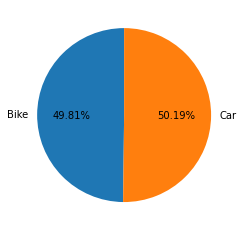

In [17]:
plt.pie(len_dir , labels = name_dir , autopct='%1.2f%%', startangle = 90)
plt.show()

###### input image size format is 60
###### Batch size la 32
https://docs.w3cub.com/tensorflow~2.3/keras/preprocessing/image_dataset_from_directory


In [18]:
IMAGE_SIZE = 60
BATCH_SIZE = 32
CHANNELS = 3

In [19]:
Data = tf.keras.preprocessing.image_dataset_from_directory(
'Car-Bike-Dataset',
batch_size = 32,
image_size = (IMAGE_SIZE , IMAGE_SIZE),
shuffle = True
)

Found 3981 files belonging to 2 classes.


In [20]:
print('Number Batch : {}'.format(len(Data)))

Number Batch : 125


In [21]:
class_names = Data.class_names
len_class = len(Data.class_names)
print(class_names)
print(len_class)

['Bike', 'Car']
2


In [22]:
# 1 cho biet kich thuoc cua mot anh va so anh trong 1 bo
# cho thay duoc nhan 0 - 1 duoc gan vao anh
for image_batch, label_batch in Data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 60, 60, 3)
[0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1]


In [23]:
# ham dung de show anh
def show_img(Data , number_img = [4,3]):
    plt.figure(figsize = (10 ,10))
    for image_batch, label_batch in Data.take(1):
        for i in range(number_img[0]*number_img[1]):
            ax = plt.subplot(number_img[0],number_img[1],i+1)
            plt.imshow(image_batch[i].numpy().astype('uint8'))
            plt.title(class_names[label_batch[i]]+' - label : {}'.format(label_batch[i].numpy()))
            plt.axis('off')

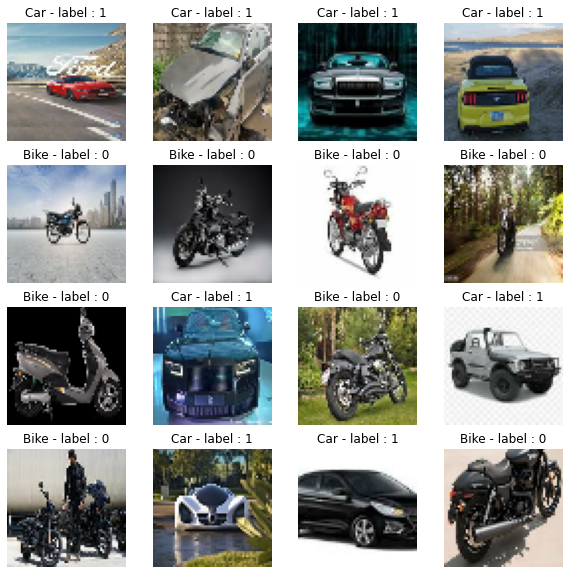

In [24]:
show_img(Data , [4,4])

In [25]:
# chia du lieu thanh 3 phan Train, Val , Test
def setting_data(data , train_scale = 0.8 , val_scale = 0.1, test_scale = 0.1,Shuffle = 1000):
    if Shuffle:
        data = data.shuffle(Shuffle,seed = 20)
    v_train = int(len(data)*0.8)
    v_val = int(len(data)*0.1)
    Train = data.take(v_train)
    Val = data.skip(v_train).take(v_val)
    Test = data.skip(v_train).skip(v_val)
    return Train, Val , Test

In [26]:
Train , Val , Test = setting_data(Data,Shuffle = 40)

In [27]:
print('Number Train : {}'.format(len(Train)))
print('Number Test : {}'.format(len(Val)))
print('Number Test : {}'.format(len(Test)))

Number Train : 100
Number Test : 12
Number Test : 13


In [28]:
Train = Train.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Val = Val.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Test = Test.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

# II: Build model

In [29]:
def create_model(input_shape):
    rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),])
    model = tf.keras.Sequential([
        rescale,
        #data_augmentation,

        Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape = input_shape),
        MaxPooling2D(pool_size=(2,2)),

        Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),

        Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [30]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
model = create_model(input_shape)
model.build(input_shape = input_shape)

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 60, 60, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 58, 58, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 29, 29, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 27, 27, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 13, 13, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (32, 13, 13, 32)         

In [32]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [248]:
# cp_callback bien nay giup vua train vua save neu co ngat doan ta van co the tiep tuc train 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(Train,validation_data=Val, epochs=50 , batch_size = BATCH_SIZE,verbose = 1,callbacks=[cp_callback])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5652 - binary_accuracy: 0.6822
Epoch 1: saving model to training_1\cp.ckpt
100/100 [==============================] - 147s 1s/step - loss: 0.5652 - binary_accuracy: 0.6822 - val_loss: 0.3269 - val_binary_accuracy: 0.8802
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.2880 - binary_accuracy: 0.8841
Epoch 2: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 123ms/step - loss: 0.2880 - binary_accuracy: 0.8841 - val_loss: 0.2710 - val_binary_accuracy: 0.8906
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.2506 - binary_accuracy: 0.8988
Epoch 3: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 121ms/step - loss: 0.2506 - binary_accuracy: 0.8988 - val_loss: 0.2282 - val_binary_accuracy: 0.9141
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.2131 - binary_accuracy: 0.9144
Epoch 4: savin

Epoch 29/50
100/100 [==============================] - ETA: 0s - loss: 0.0468 - binary_accuracy: 0.9828
Epoch 29: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 119ms/step - loss: 0.0468 - binary_accuracy: 0.9828 - val_loss: 0.1009 - val_binary_accuracy: 0.9688
Epoch 30/50
100/100 [==============================] - ETA: 0s - loss: 0.0410 - binary_accuracy: 0.9859
Epoch 30: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 119ms/step - loss: 0.0410 - binary_accuracy: 0.9859 - val_loss: 0.0746 - val_binary_accuracy: 0.9688
Epoch 31/50
100/100 [==============================] - ETA: 0s - loss: 0.0381 - binary_accuracy: 0.9869
Epoch 31: saving model to training_1\cp.ckpt
100/100 [==============================] - 12s 119ms/step - loss: 0.0381 - binary_accuracy: 0.9869 - val_loss: 0.0638 - val_binary_accuracy: 0.9818
Epoch 32/50
100/100 [==============================] - ETA: 0s - loss: 0.0323 - binary_accuracy: 0.9869
Epoch

In [249]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

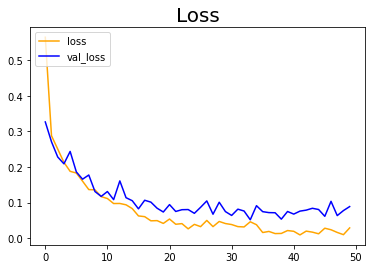

In [250]:
plt.plot(history.history['loss'], color = 'orange',label= 'loss')
plt.plot(history.history['val_loss'], color = 'blue',label= 'val_loss')
plt.title('Loss',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

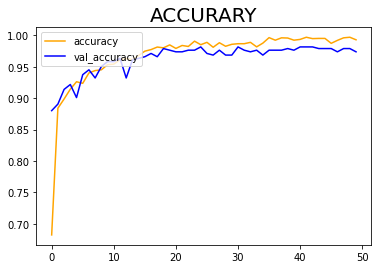

In [251]:
plt.plot(history.history['binary_accuracy'], color = 'orange',label= 'accuracy')
plt.plot(history.history['val_binary_accuracy'], color = 'blue',label= 'val_accuracy')
plt.title('ACCURARY',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [252]:
Test_model = model.evaluate(Test)

13/13 [==============================] - 27s 28ms/step - loss: 0.0509 - binary_accuracy: 0.9808


### Loadi model

In [33]:
chack_path = 'training_1'

In [34]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

In [35]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [36]:
new_model = create_model(input_shape)

In [37]:
new_model.load_weights(latest)

In [71]:
def test_img(model , test_ds ,number = [3,3] , img_size = 60):
    list_name = os.listdir(test_ds)
    number_img = len(list_name)
    plt.figure(figsize = (15 ,15))
    for img in range(number[0]*number[1]):
        index_img = random.randint(0,number_img-1)
        name_img = list_name[index_img]
        path_img = os.path.join(test_ds , name_img)
        test_image2 = tf.keras.utils.load_img(path_img, target_size=(img_size,img_size))
        test_image2 = np.expand_dims(test_image2, axis=0)
        prediction = new_model.predict(test_image2)
        if prediction > 0.5:
            title = 'Car with accuracy {}'.format(prediction)
        else:
            title = 'Bike with accuracy {}'.format(1- prediction)
        
        plt.subplot(number[0], number[1], img +1)
        plt.imshow(test_image2[0])
        plt.axis('off')
        plt.title(title)

1/1 [==============================] - 0s 25ms/step


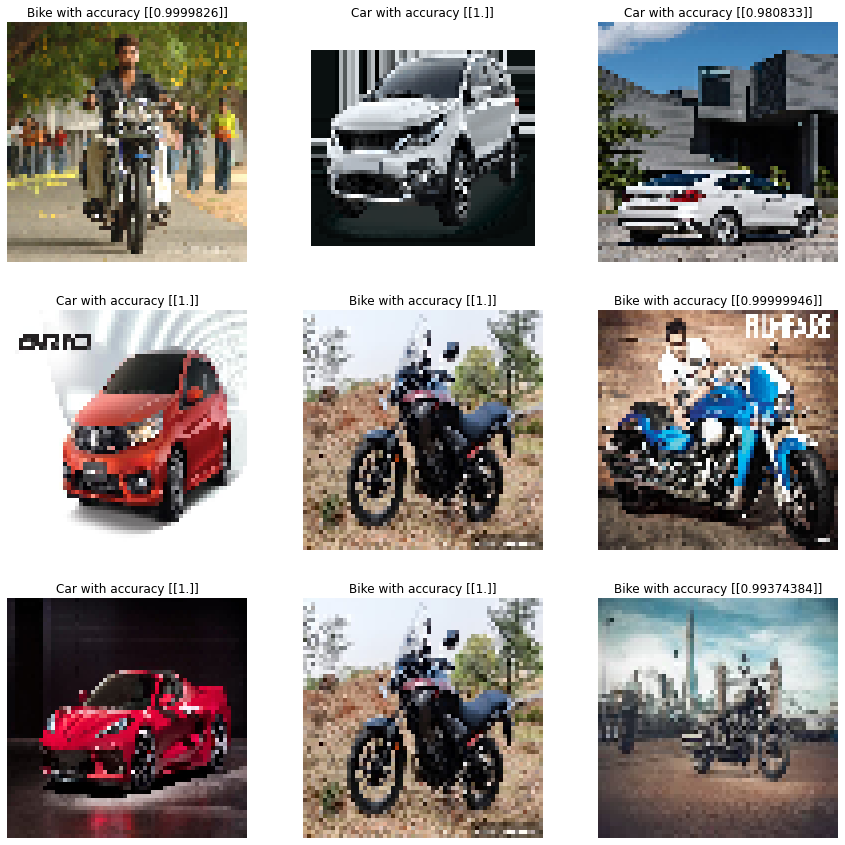

In [72]:
dir_test_model = 'Test'
test_img(new_model , dir_test_model , [3,3],60)